In [2]:
import numpy as np


def fn_test(arr):
    return arr[0, 0]**2 + arr[0, 1]**4

def ls_test(arr, eps=1e-3):
    N = arr.shape[1]
    res = np.zeros((1, N))

    for j in range(10):
        A = np.zeros((0, N))
        for i in range(N):
            arr_prim = arr.copy()
            arr_prim[0, i] = arr_prim[0, i] + eps
            r1 = fn_test(arr_prim)
            arr_prim[0, i] = arr_prim[0, i] - 2*eps
            r2 = fn_test(arr_prim)
            res[0, i] = (r1 - r2) / (2 * eps)
        A = np.concatenate((A, res), 0)

        arr = arr - (A * eps)
        print(arr)
    
x0 = np.matrix([10.0, -10, 3, 4, 5, 6])
t = fn_test(x0)
ls_test(x0)

[[ 9.98       -5.99999996  3.          4.          5.          6.        ]]
[[ 9.96004    -5.13599995  3.          4.          5.          6.        ]]
[[ 9.94011992 -4.59408013  3.          4.          5.          6.        ]]
[[ 9.92023968 -4.20623735  3.          4.          5.          6.        ]]
[[ 9.9003992  -3.90856305  3.          4.          5.          6.        ]]
[[ 9.8805984  -3.66972067  3.          4.          5.          6.        ]]
[[ 9.86083721 -3.47204235  3.          4.          5.          6.        ]]
[[ 9.84111553 -3.30461937  3.          4.          5.          6.        ]]
[[ 9.8214333  -3.16026685  3.          4.          5.          6.        ]]
[[ 9.80179043 -3.03401687  3.          4.          5.          6.        ]]


In [12]:
from scipy.optimize import least_squares

def func(x):
    print(x)
    return np.array([x[0] - 1, x[1] + 1.5])

x0 = np.array([2, 2, 3])
res = least_squares(func, x0, tr_solver='lsmr')
print(res)

[2. 2. 3.]
[2.00000003 2.         3.        ]
[2.         2.00000003 3.        ]
[2.         2.         3.00000004]
[ 1.  -1.5  3. ]
[ 1.00000001 -1.5         3.        ]
[ 1.         -1.50000002  3.        ]
[ 1.         -1.5         3.00000004]
 active_mask: array([0., 0., 0.])
        cost: 4.190823558986625e-31
         fun: array([-2.22044605e-16, -8.88178420e-16])
        grad: array([-2.22044605e-16, -8.88178420e-16,  0.00000000e+00])
         jac: array([[ 1., -0.,  0.],
       [ 0.,  1.,  0.]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 2
        njev: 2
  optimality: 8.881784197001252e-16
      status: 1
     success: True
           x: array([ 1. , -1.5,  3. ])


In [12]:
from topocalib.model_cv import get_pixel_coordinates


CHECKERBOARD = (6,19)
chess = np.zeros(shape=(CHECKERBOARD[0] * CHECKERBOARD[1], 3))
for i in range(CHECKERBOARD[0] * CHECKERBOARD[1]):
    chess[i] = np.array([ i % CHECKERBOARD[0], int(i / CHECKERBOARD[0]), 0])

multi_chess = np.concatenate((chess + np.array([0, 0, 2]), chess + np.array([0, 0, 5])), axis=0)
    

ks = [0.0, 0.0, 0.0]
C = [800]
center = [1400, 1400]
X_ws = [
    multi_chess,
    multi_chess,
    multi_chess,
    multi_chess
]
Ts = [
    np.array([-9.5, -5.7, 4]),
    np.array([-4, -6, 3]),
    np.array([-1, -1, 3]),
    np.array([0, -2, 3]),
]
Rs = [
    np.array([0.1, -0.2, -0.8]),
    np.array([0.1, -0.1, 0.3]),
    np.array([0.0, -0.0, 0.1]),
    np.array([0.0, -0.1, 0.1]),
]

X_cs = []


for X_w, T, R in zip(X_ws, Ts, Rs):
    arr = np.empty([0, 2])
    for point in X_w:
        px = get_pixel_coordinates(T, R, point, ks, C, center)
        arr = np.append(arr, np.transpose(px), axis=0)
    X_cs.append(arr)

In [26]:
import sympy as sp
from sympy import Matrix
from sympy.tensor.array import Array


def get_rotation(R):
        coss = sp.cos(R)
        sins = sp.sin(R)

        A = Matrix([
                [1, 0, 0],
                [0, coss[0], -sins[0]],
                [0, sins[0], coss[0]
        ]]) 
        B = Matrix([
                [coss[1], 0, sins[1]],
                [0, 1, 0],
                [-sins[1], 0, coss[1]]
        ])
        C = Matrix([
                [coss[2], -sins[2], 0],
                [sins[2], coss[2], 0],
                [0, 0, 1]
        ])

        return A*B*C

def get_r(X_hom):
    return sp.sqrt(X_hom[0] ** 2 + X_hom[1] ** 2)


def get_theta(r):
    return sp.arctan(r)


def get_theta_distorted(theta, ks):
    s = theta
    for i, k in enumerate(ks):
        s += k * theta ** (2*i+3)
    return s


def get_x_camera(T, R, X_w):
    rotation = get_rotation(R) * Matrix(X_w).T
    translation = rotation + Matrix(T).T
    return Array(translation)


def get_x_camera_pre(tranlsation, rotation, X_w):
    return Array(rotation * Matrix(X_w).T + tranlsation)


def get_x_distorted(X_hom, r, theta_d):
    return Array([
        (theta_d / r) * X_hom[0],
        (theta_d / r) * X_hom[1]
    ])


def get_pixel_coordinates(T, R, X_w, ks, C, center):
    X_c = get_x_camera(T, R, X_w)
    return get_pixel_coordinates_xc(X_c, ks, C, center)


def get_pixel_coordinates_xc(X_c, ks, C, center):
    f_x = C
    f_y = C
    
    # Homegenious coordinates of object in camera frame
    X_hom = Array([X_c[0] / X_c[2], X_c[1] / X_c[2]])
    
    # Radious
    r = get_r(X_hom)
    
    # Theta distorted
    theta = get_theta(r)
    theta_d = get_theta_distorted(theta, ks)
    
    # Coordinates of object taking distortion into account
    X_d = get_x_distorted(X_hom, r, theta_d)
    
    # Pixel coordinates
    X_p = np.array([
        f_x * X_d[0] + center[0],
        f_y * X_d[1] + center[1]
    ])
    return X_p


def ls_func2(params, Xs_worlds, Xs_distorteds):
    """
    Function used for least-square optimisation
    """

    ks = params[0:3]
    C = params[3]
    center = params[4:6]

    s = []
    i = 6
    for Xs_world, Xs_distorted in zip(Xs_worlds, Xs_distorteds):
        T = params[i:i+3]
        R = params[i+3:i+6]

        rotation = get_rotation(R)
        translation = Matrix(T).T
        for X_w, X_d in zip(Xs_world, Xs_distorted):
            X_c = get_x_camera_pre(translation, rotation, X_w)
            X_pixel = get_pixel_coordinates_xc(X_c, ks, C, center)
            s.append(X_pixel[0, 0] - X_d[0])
            s.append(X_pixel[1, 0] - X_d[1])
        i += 6
    return Array(s)

In [28]:
from sympy import symbols, diff


ks=[0.0, 0.0, 0.0]
center=[1400, 1400]
T=[1,1,5]
R=[0.1,0.1,0.1]
C=[800]

x0 = ks + C + center
for objps, corners in zip(X_ws, X_cs):
    x0 += T + R

n_core_params = len(x0)
n_points = X_cs[0].shape[0] * X_cs[0].shape[1]
n_images = len(X_cs)
n_params = n_core_params + n_images * 6

s = symbols(f'a0:{n_params}')
print(s)


diff(ls_func2(s, X_ws, X_cs), s[0])



(a0, a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, a11, a12, a13, a14, a15, a16, a17, a18, a19, a20, a21, a22, a23, a24, a25, a26, a27, a28, a29, a30, a31, a32, a33, a34, a35, a36, a37, a38, a39, a40, a41, a42, a43, a44, a45, a46, a47, a48, a49, a50, a51, a52, a53)


AttributeError: 'Tuple' object has no attribute 'could_extract_minus_sign'

In [2]:
import matplotlib.pyplot as plt

%matplotlib widget

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.random.rand(10))
text=ax.text(0,0, "", va="bottom", ha="left")

def onclick(event):
    tx = 'button=%d, x=%d, y=%d, xdata=%f, ydata=%f' % (event.button, event.x, event.y, event.xdata, event.ydata)
    text.set_text(tx)

cid = fig.canvas.mpl_connect('button_press_event', onclick)

FigureCanvasNbAgg()

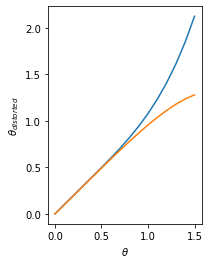

In [42]:
import matplotlib.pyplot as plt

D = [
    np.array([0.01668148, -0.16109292,  0.22340004,   0. ]),
    np.array([-0.0526964, 0.086476,  -0.077636,   0. ]),
]

t = np.arange(0, np.pi / 2, 0.1)
thetas = []

fig, ax = plt.subplots(1, 1)

for i in range(len(D)):
    thetas.append(t + t**2 * D[i][0] + t**3 * D[i][1] + t**4 * D[i][2])

ax.plot(t, thetas[0])
ax.plot(t, thetas[1])
ax.set_xlabel(r'$ \theta $')
ax.set_ylabel(r'$ \theta_{distorted} $')
ax.set_aspect('equal')